# Tutorial 2 - Page rank, plotting and more numpy gymnastics

In this exercise, we will implement and play with the page rank algorithm.
As seen in the lecture, the page rank algorithm allows to take a graph (e.g. the internet graph) and rank its nodes (the websites) in order of importance, or relevance, to the rest of the graph.  Of course, we can apply the page rank algorithm also to other graphs, not only to the internet.

In exercise 1, we play with the novel "Les Miserables". We construct the graph of co-occurencies of the characters: each character of the novel is a node of the graph (a website in the internet example) and each pair of characters is linked if they appear together in at least one scene. We will use pagerank to identify the most relevant characters of the novel.
We will then compare the pagerank algorithm with the direct computation of the leading eigenvector using numpy's eigen-decomposition utilities.

In exercise 2, we implement page rank for a much larger graph, the graph of links in the wikipedia of simple english. This will require some care in the implementation to run efficiently - for this we will use the sparse matrix format and think about how to re-express a single pagerank iteration more efficiently.

Exercise 3 consists in a few theoretical questions similar to those asked in the exam.

The theoretical tools used in this tutorial are those of section 1 of the lecture notes (eigenvalues, the power method and the page rank algorithm).

# Exercise 1 : Les Miserables

In [97]:
# importing libraries we need later
import numpy as np
import matplotlib.pyplot as plt

## 1.a Loading the data and visualization
For starters, we go for the dataset of co-occurences in a scene between the characters of "Les Miserables". This containes 77 characters and counts for every pairs if they appear together. 

Note that in the beginning of this notebook, we already imported all the proprietary libraries we will need. You know `numpy` for arrays and vectors, but we added `matplotlib` we will use for plotting later. 

To load the data from Les Miserables, the TAs wrote some code to import it. Since it is not important that you read/understand it, we put the code in a separate file in this directory `utils.py`.

To use the functions defined in there for data loading and visualization, we simply use:

In [98]:
# import from current directory, a function to visualize the toy graph
from utils import load_les_miserables, plot_les_miserables

It is a nice way to keep code orderly and reuse it later. For more info on this, see [this Tutorial](https://www.geeksforgeeks.org/python-modules/).

You can now use these functions like any other function coming from a library like numpy. You do not need to use a prefix like `np.your_function()` though, because we imported the functions directly via the `from ... import ...` statement.

In [99]:
# This function returns
# n: number of characters
# names: of the characters
# A: (n,n) matrix where A[i,j] counts common appearences
n, names, A = load_les_miserables()

- Given the indices associated to character 0 and character 17, find their names and, check whether these two co-occur in the story. Compute the number of appearances each one of them has.

In [100]:
# by putting the f in front of a string, you can evaluate expressions
# directly in a string
# bool(.) converts 1 to True and 0 to False
f"{names[0]} and {names[17]} appear together: {bool(A[0,14])}."

'Napoleon and Tholomyes appear together: False.'

In [101]:
f"{names[0]} appears {A[:,0].sum()} times."

'Napoleon appears 1 times.'

In [102]:
f"{names[17]} appears {A[:,17].sum()} times."

'Tholomyes appears 9 times.'

To get a feeling for how the matrix looks like, we want to plot it using `plt.imshow` from the [matplotlib library](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html), probably the most basic and important library for plotting in python.
By sending commands to the `plt` module, one procedurally builds a plot.
- Use `plt.imshow` to display the matrix $A$ and title the plot 'The adjacency matrix A'.

Text(0.5, 1.0, 'The adjacency matrix A')

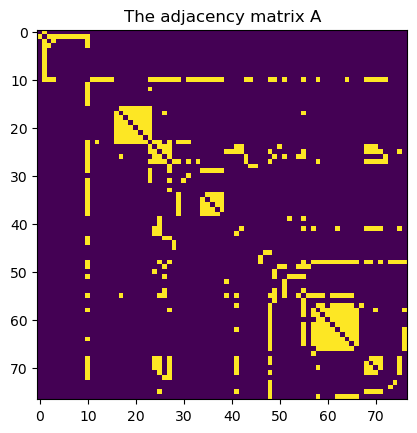

In [103]:
# using the matplotlib library 
# visualize the 2D matrix A
# set a title
# show the plot
plt.imshow(A)
plt.title('The adjacency matrix A')


- What property can you deduce about the network from the image ? Does this make sense given the considered data ?

> The graph is not directed (it is symmetric): If node A points to node B, then also B points to A. This means that every edge is bidrectional. We will come to directed examples later when we look at internet data where a link points from a site A to a site B, but not necessarily the other way around. 

## 1.b Creating the page rank matrix $G$

We now want to find the PageRank $w_i$ of every member $i$ of the Les Miserables cast. How can we interpret such a value? 
Essentially, $w_i$ will be high for members that have many appearences with different cast members, i.e. that are 'central' in the cast graph.

To find out who these members are, let's go on to define the matrix used in the algorithm using the notation from the lecture:

Recall from the lecture, the definition of the pagerank matrix $G$.
$$
G = (1-\epsilon)S+\epsilon \frac{1}{n}\\
$$
with
$$
S_{ij} = A_{ij}/d_j\quad \mathrm{if } \,\,\,d_j > 0\ ,\quad
S_{ij} = 1/n\quad \mathrm{if }\,\,\,d_j = 0
$$
and $A$ is the adjacency matrix of the underlying graph, so $A_{ij}=1$ if there is an link from $j$ to $i$ and it is zero otherwise.
Since every node in our current example is connected, we can brush over the case $d_j=0$ for now.

In [104]:
# set the dampening parameter
eps = 0.05

Compute the outgoing edges that a node $i$ has by summing over the column $d_j = \sum_i A_{ij}$

In [105]:
# calculate the vector degrees of size (n) which contains d_j
degrees = A.sum(axis=0)

In [106]:
# the degree of node 'Woman1' and 'Javert'
# here, using the double == gives a boolean mask, which subsequently only selects 
# entries that are true
neigh_wmn = degrees[names=='Woman1']
neigh_javert =  degrees[names=='Javert']
f'Woman1 has {neigh_wmn} pair appearences, Javert has {neigh_javert} pair appearences'

'Woman1 has [2] pair appearences, Javert has [17] pair appearences'

- Now we want to compute the matrix $S$. For this, we use [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).

In [107]:
# compute the matrix S
S = A / degrees # s_ij = a_ij / d_j

In [108]:
A

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [109]:
degrees

array([ 1, 10,  3,  3,  1,  1,  1,  1,  1,  1, 36,  1,  2,  1,  1,  1,  7,
        9,  7,  7,  7,  7,  7, 15, 11, 16, 11, 17,  4,  8,  2,  4,  1,  2,
        6,  6,  6,  6,  6,  3,  1, 11,  3,  3,  2,  1,  2,  1, 22,  7,  2,
        7,  2,  1,  4, 19,  2, 11, 15, 11,  9, 11, 13, 12, 13, 12, 10,  1,
       10, 10, 10,  9,  3,  2,  2,  7,  7])

In [110]:
A/degrees

array([[0.        , 0.1       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

- Propose a piece of code to check that your $S$ matrix makes sense.

In [111]:
# check e.g. that column 23 sums to 1
S[:,23].sum()

1.0

In [112]:
# compute G
G = (1-eps)*S+eps/n

## 1.c Running the power iteration

We now have all the ingredients to run PageRank. We initialize the weight vector $w$ uniformly and then update it iteratively via $w = Gw$ until the changes per iteration are not too big (the iterations converge).

We measure this change at every iteration, track it and plot the convergence.

- Initilize $w$ uniformly with $1/n$.

In [113]:
# create a vector w of length n with weight uniformly distributed
w = np.ones(n)/n

- Run the pagerank iteratively until w changes less than 1e-10 between two iterations. Keep track of the distance between the updated and old $w$ in a list, so that we can visualize it after.

In [114]:
# track distance and convergence
dist = 1e300
dists = []
# a while loop is run, until the condition at the beginning is False
while dist > 1e-10:
    w = G @ w
    dist = np.linalg.norm(w-G @ w)
    dists.append(dist)

- Plot the list of distances using `plt.plot` and label the x (time) and y (distance) axis accordingly.

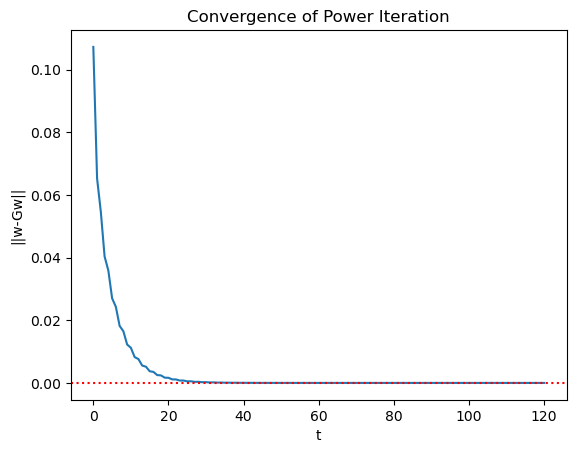

In [115]:
# we plot the list of the distance values as a function of time
plt.plot(dists)
plt.axhline(np.linalg.norm(w - G @ w),color='red',linestyle='dotted')
plt.xlabel('t')
plt.ylabel('||w-Gw||')
plt.title('Convergence of Power Iteration');

## 1.d Comparison against the `np.linalg` eigendecomposition 

For this we use numpy `linalg` module to compute the eigenvalues and vectors for a matrix. Since the poweriteration is computing $w$, such that $w=Gw$, we need to check for the eigenvalue $\lambda=1$.

However, $G$ may not be symmetric, so some eigenvalues may be complex. Therefore, the eigenvalue $1$ we are be looking for is the largest in complex norm.

In [116]:
# use numpys code to do the eigenvalue decomp
eigenvalues, eigenvectors = np.linalg.eig(G)

In [117]:
# the complex values eigenvalue and eigenvector at position 3
# the eigenvectors are organized in a matrix, where the ith column belongs to the ith eigenvalue
eigenvalues[3], eigenvectors[:,3]

((0.8064824421368109+0j),
 array([-0.03142441+0.j, -0.26677091+0.j, -0.02806124+0.j, -0.02806124+0.j,
        -0.03142441+0.j, -0.03142441+0.j, -0.03142441+0.j, -0.03142441+0.j,
        -0.03142441+0.j, -0.03142441+0.j,  0.43951833+0.j,  0.01438147+0.j,
         0.01161503+0.j,  0.01438147+0.j,  0.01438147+0.j,  0.01438147+0.j,
        -0.11162947+0.j, -0.11413478+0.j, -0.11162947+0.j, -0.11162947+0.j,
        -0.11162947+0.j, -0.11162947+0.j, -0.11162947+0.j, -0.03522757+0.j,
         0.06683161+0.j,  0.06816096+0.j,  0.05691123+0.j,  0.14409749+0.j,
         0.06845822+0.j,  0.26732297+0.j,  0.00434873+0.j,  0.02416106+0.j,
         0.01438147+0.j,  0.02436619+0.j,  0.25032184+0.j,  0.25032184+0.j,
         0.25032184+0.j,  0.25032184+0.j,  0.25032184+0.j,  0.00524097+0.j,
         0.00501816+0.j,  0.01766551+0.j,  0.01406669+0.j,  0.03046064+0.j,
         0.03454164+0.j,  0.02016018+0.j, -0.02258656+0.j, -0.01330297+0.j,
        -0.12917097+0.j,  0.03430656+0.j,  0.01292987+0.j,  0.

In [149]:
# We sort the eigenvalues by their norm, using `np.absolute`
sorted_idx = np.argsort(np.absolute(eigenvalues))

In [151]:
sorted_idx

array([71, 74, 75, 61, 76, 73, 72, 70, 69, 68, 67, 66, 65, 41, 42, 44, 47,
       32, 50, 54, 51, 31, 53, 30, 49, 52, 48, 46, 45, 29, 57, 64, 63, 56,
       58, 62, 59, 55, 60, 43, 40, 23, 39, 38, 37, 21, 20, 36, 34, 19, 33,
       18, 35, 17, 28, 27, 26, 15, 25, 22, 12, 11, 24, 16, 10, 14, 13,  8,
        7,  6,  9,  5,  3,  4,  2,  1,  0], dtype=int64)

- Check what `np.argsort` does, and find the index from `sorted_idx` of the largest element in `eigenvalues`. Then, using this index, select the corresponding eigenvector and norm it to be a probability distribution. Then compare it to the pagerank values $w$. Do they match?

In [119]:
# Take the index of the largest element, now positioned a the end of the array, due to ascending order.
idx = sorted_idx[-1]

In [148]:
# select the respective eigenvector from the matrix
eigv = eigenvectors[:,idx]
eigv

array([0.02533913+0.j, 0.22144899+0.j, 0.0561884 +0.j, 0.0561884 +0.j,
       0.02533913+0.j, 0.02533913+0.j, 0.02533913+0.j, 0.02533913+0.j,
       0.02533913+0.j, 0.02533913+0.j, 0.49476412+0.j, 0.01735776+0.j,
       0.02933894+0.j, 0.01735776+0.j, 0.01735776+0.j, 0.01735776+0.j,
       0.08701045+0.j, 0.11069985+0.j, 0.08701045+0.j, 0.08701045+0.j,
       0.08701045+0.j, 0.08701045+0.j, 0.08701045+0.j, 0.18917654+0.j,
       0.13758021+0.j, 0.19837824+0.j, 0.14128606+0.j, 0.21460062+0.j,
       0.0630046 +0.j, 0.10598098+0.j, 0.02941751+0.j, 0.05530464+0.j,
       0.01735776+0.j, 0.02935014+0.j, 0.08166272+0.j, 0.08166272+0.j,
       0.08166272+0.j, 0.08166272+0.j, 0.08166272+0.j, 0.0421402 +0.j,
       0.01608019+0.j, 0.13131463+0.j, 0.03930293+0.j, 0.04155212+0.j,
       0.03232135+0.j, 0.01926507+0.j, 0.03590874+0.j, 0.02135813+0.j,
       0.26207873+0.j, 0.0943218 +0.j, 0.02898422+0.j, 0.0979516 +0.j,
       0.03093931+0.j, 0.01759491+0.j, 0.05396155+0.j, 0.22727686+0.j,
      

In [121]:
# norm the eigenvector to be a probability distribution, so that we can directly compare to pagerank
eigv = eigv/eigv.sum()

In [122]:
# compare the eigenv from the eigendecomposition with the the pagerank result
np.abs(eigv-w).sum()

3.4273947287048745e-09

## 1.e Interpreting the results

We are looking for central characters whose interactions are central. Are these the characters that also are the main characters in the story, such as percieved by respected scholars such as ChatGPT? 

> Can you give me a list of the ten main characters in Les Miserables, in the form of a python list?



```
main_characters = [
    "Valjean",
    "Javert",
    "Cosette",
    "Marius",
    "MmeThenardier",
    "Thenardier",
    "Fantine",
    "Gavroche",
    "Enjolras",
    "Myriel"
]
```

- To compare to those we need to extract the names of the nodes with the highest 10 page rank weights.

In [123]:
# return a sorted index by page rank weight (ascending order)
sorted_importance = np.argsort(w) 

In [124]:
# the ten most central characters are those, with the highest page rank
ten_most_central_characters = names[sorted_importance][-10:]
list(ten_most_central_characters)

['Courfeyrac',
 'Bossuet',
 'Enjolras',
 'Fantine',
 'Thenardier',
 'Javert',
 'Myriel',
 'Marius',
 'Gavroche',
 'Valjean']

... the central characters seem also be the main ones, they are interacting with one another a lot!

We can also look at them in the graph view:

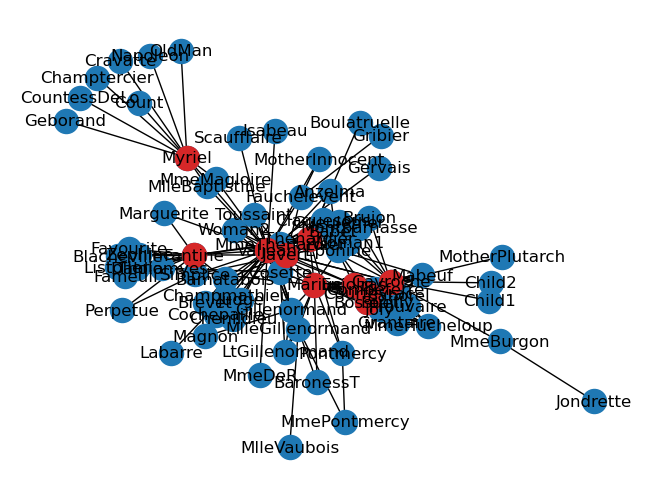

In [125]:
plot_les_miserables(highlight_names=ten_most_central_characters,layout='spring')

- It looks like the nodes with a high page rank value have also high degree. Check this by plotting the weight $w$ and the degree $d$ against one another on a scatterplot using `plt.scatter`. Don't forget to label the axes.

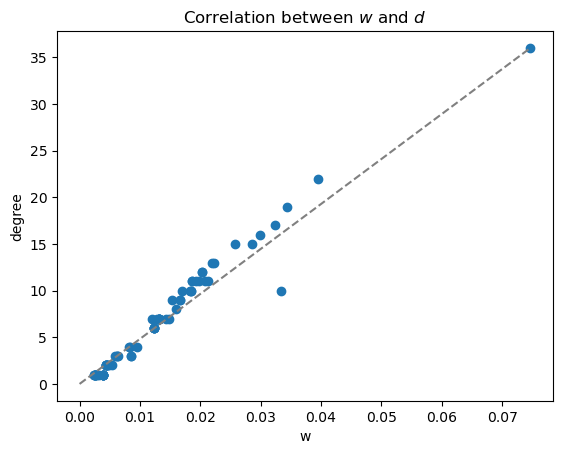

In [126]:
# also, we plot the distribution of the page rank values w
plt.scatter(w,degrees)
x = np.linspace(0,w.max(),30)
y = np.linspace(0,degrees.max(),30)
plt.plot(x,y,c='grey',linestyle='dashed')
plt.xlabel('w')
plt.ylabel('degree')
plt.title('Correlation between $w$ and $d$');

# Exercise 2: The simple wikipedia link database

We now want to use PageRank on the [DBpedia link dataset](https://databus.dbpedia.org/dbpedia/generic/wikilinks/). We use the collection of all links between wikipedia pages that appear in the article collection of [simple english wikipedia](https://simple.wikipedia.org/wiki/Main_Page), which aims to explain things in understandable easy terms. It has ~ 1.3 Mio articles and categories, which is big - but not too big to run on a Laptop.

This will help us understand what the most central (or general) articles in this wikipedia database are.


In [127]:
from utils import load_simple_wikipedia
# load the dbpedia adjacency matrix and the names of the articles
names, A = load_simple_wikipedia()

In [147]:
A

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 5343446 stored elements and shape (1349256, 1349256)>

- How many entities does the simple english wikipedia have exactly?

In [128]:
n = A.shape[0]
n

1349256

## 2.a Data Inspection: Does the loaded data 'make sense'?

Page # 13997 is [Electricity](https://simple.wikipedia.org/w/index.php?title=Electricity&oldid=8522069). We can use the list of names to verify this.

In [129]:
names[13997]

'Electricity'

The format of the array is now in [sparse row format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_array.html#scipy.sparse.csr_array), because this makes saving and computing matrix products much cheaper. You can use `type` to check the type of a variable (it is similar to a C++ class).

In [130]:
type(A)

scipy.sparse._csr.csr_matrix

Let's look at the pages 'Electrictiy' is linking to.

The interface of the sparse matrix is slightly different than `np.array`. When we select a column, we first need to convert it back to a numpy array to use it like before.

In [131]:
type(A[:,13997].toarray())

numpy.ndarray

But then it has one extra dimension.

In [132]:
A[:,13997].toarray().shape

(1349256, 1)

So we squish it.

In [133]:
A[:,13997].toarray().flatten().shape

(1349256,)

And then we can use it to find the names of the pages that are linked from electricity (are not 0).

In [134]:
names[A[:,13997].toarray().flatten() != 0]

array(['Electric_motor', 'Electrical_engineering', 'Universe', 'Metal',
       'Battery', 'Nature', 'Electronics', 'Lightning', 'Atom',
       'Molecule', 'Benjamin_Franklin', 'Water', 'Engineering',
       'Estimate', 'Electric_power', 'Turbine', 'Steam_engine', 'Proton',
       'Category:Basic_English_850_words', 'Electron', 'Hydropower',
       'Renewable_energy', 'Insulator_(electricity)', 'Watt', 'Ohm',
       'Copper', 'Volt', 'Energy', 'Magnet', 'Static_electricity',
       'Electrons', 'Category:Electricity', 'Theophrastus', 'Movement',
       'Magnetic_field', 'Steam', 'Electric_current', 'Salt',
       'Non-renewable_resource', 'Wind_power', 'Thales',
       'Electric_charge', 'Machine', 'Ammeter', 'Light_bulb', 'Wire',
       'Power_line', 'Thunderstorm', 'Heating', 'Electrical_circuit',
       'Electric_field', 'Joule', 'Michael_Faraday',
       'Electromagnetic_induction', 'Neutral', 'Electrical_energy',
       'Particles', 'Electrical_conductor', 'Joules', 'Power_station'

- Can we similarly find the pages linking to 'Electricity'? How do the list of the terms linking to and from the main page differ?

In [135]:
names[A[13997,:].toarray().flatten() != 0]

array(['South_Region,_Brazil', 'Color_blindness', 'Slum',
       'Electrical_engineering', 'Human', 'City', 'Silicon',
       'Electromagnetism', 'Morwell,_Victoria', 'Engine', 'Earth',
       'Cable', 'October_9', 'Metal', 'Battery', 'Airbus_A330',
       'String_theory', 'Electronics', 'Judaism', '2012', 'Natural_gas',
       'Computer', 'Siméon_Denis_Poisson', 'Solid', 'Book',
       'List_of_tallest_structures_in_the_world', 'Brass', 'Chris_Huhne',
       'Lightning', 'Ground', 'June_11', 'Virginia_Beach,_Virginia',
       'Drill', '2013', 'Lake', 'Atom', 'Physics', 'November_8',
       'Dipole_antenna', 'Electricity_meter', 'Fire_extinguisher',
       'Cryogenics', 'ARM_architecture', 'Diode', 'June_16',
       'List_of_phobias', 'Demolition', 'Aluminium', 'September_20',
       'Plasma_(physics)', 'Freelan_Oscar_Stanley', 'Diesel_locomotive',
       'Al_Jazeera', 'Nashville,_Tennessee', 'Lawrence,_Kansas',
       'Benjamin_Franklin', 'Electric_multiple_unit', '1820',
       'Auto

Some extra questions:

- How many entities have no outgoing links?

In [136]:
(A.sum(axis=0)==0).sum()

1038300

- How many entities have no incoming links?

In [137]:
(A.sum(axis=1)==0).sum()

68083

## 2.b Implementing Page Rank using sparse matrix multiplication

To compute anything for wikipedia, we need to use the sparse matrix format and reexpress our PageRank matrix $G$ in an efficient way. Then you can easily process the data on a laptop. Recall that a sparse matrix has only few nonzero values. 
- We can check the percentage of nonzerovalues of A to see that this is indeed just a small fraction of the whole matrix.

In [138]:
(A != 0).sum() / n**2

2.935166275607265e-06

Recall that in exercise 1, we computed the matrix $G$ as follows
$$
G = (1-\epsilon)S+\epsilon \frac{1}{n}
$$
$$
S_{ij} = A_{ij}/d_j\quad \mathrm{if } \,\,\,d_j > 0\ ,\quad
S_{ij} = 1/n\quad \mathrm{if }\,\,\,d_j = 0
$$
where $A$ is the adjacency matrix of the underlying graph, so $A_{ij}=1$ if there is an edge connection (link) pointing to $i$ from $j$ and it is zero if there is no link.
Then we run the following iteration until convergence
$$
w_{t+1} = G w_{t}
$$

Now, since we now have ~1,000,000 nodes and a dense matrix would have 1,000,000,000,000 entries, it is not very efficient to use a dense matrix (np.array) directly. This is why we went for the CSR format for $A$ previously (and it was already in that format when we imported it because saving it is also more efficient). 

However, in the pagerank update the matrices $S$ and $G$ are not as sparse, so it does not make sense to represent them as a sparse matrix. 

With a bit of thinking though, we realize that we can reformulate the computation of G at every iteration such that we only work with sparse matrices multiplcations and vector products directly.

We can still rescale $\tilde{A}=A_{ij}/d_j$ which maintains the zeros of A.


For the iterative update $w=Gw$ instead do the following calculation, where adding scalars is adding it to every entry of the vector
$$
w_{t+1} = (1-\epsilon) \left(\tilde{A}w_{t} + 1/n \sum_{j | d_j = 0} w_j \right) + \epsilon * 1/n
$$
Let's construct these things step by step.

In [139]:
# First import the datatype, so that we can create a new diagonal matrix
# which divides the column j by the outgoing degree d_j
from scipy.sparse import csr_matrix

# calculate the row sums
row_sums = np.array(A.sum(axis=0)).flatten()

# prevent divide by zero error
row_sums[row_sums == 0.0] = 1.0

# create a diagonal matrix with the reciprocals of the row sums
division_matrix = csr_matrix((1 / row_sums, (range(len(row_sums)), range(len(row_sums)))), shape=(len(row_sums), len(row_sums)))

# apply the matrix 
A_tilde = A @ division_matrix

- Is the 'Electricity' column in `A_tilde` properly scaled to 1?

In [140]:
A_tilde[:,13997].sum()

1.0000000000000004

We want to build a binary mask of the $j | d_j = 0$, so we can use it in the algorithm.

In [141]:
zero_row_mask = np.array(A_tilde.sum(axis=1)).flatten() == 0

And now this is an implementation of the sparsity adapted computation.

In [142]:
# create a vector w of length n with weight uniformly distributed
w = np.ones(n)/n

# track distance and convergence
dist = np.inf
dists = []
# a while loop is run, until the condition at the beginning is False
while dist > 1e-7:
    w_new = (1-eps) * (A_tilde@w + w[zero_row_mask].sum()*1/n) + eps * 1/n
    dist = np.linalg.norm(w-w_new)
    w = w_new
    dists.append(dist)
    
#... should be done in a few seconds.

## 2.c Interpreting the results
- What are the ten most central articles? Use `np.argpartition` instead of `np.argsort`. Why is this the better choice?

In [143]:
ten_most_central_articles = names[np.argpartition(w,-10)][-10:]
list(ten_most_central_articles)

['India',
 'U.S._state',
 'United_Kingdom',
 'Germany',
 'Departments_of_France',
 'City',
 'Category:Living_people',
 'France',
 'United_States',
 'Communes_of_France']

## 2.d Bounus Question

As an open bonus exercise, we want to know which of the terms 'Physics', 'Chemistry', 'Computer Science', 'Biology', 'Mathematics' is most central in simple english wikipedia. Can you extract the pagerank of these articles and compare their ranks? 

# Exercice 3: Theoretical questions for the exam

1. Donnez la matrice d’adjacence $A \in \{0, 1\}^{5\times 5}$ du réseau de sites web donné ci-dessous. $A_{ij} = 1$ si le site web $j$
a un lien vers le site web $i$, sinon $A_{ij} = 0$. Les indices $i$ et $j$ indiquent respectivement les lignes et les colonnes de $A$.

![Image](data/graphe.png)

Solution :

$$A = 
\begin{pmatrix}
0 & 1 & 0 & 1 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 1 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
1 & 0 & 1 & 1 & 0
\end{pmatrix}
$$

2. Quel site web a le plus grand degré sortant (out-degree) ? Quel site web a le plus grand degré entrant
(in-degree) ?


Solution :

Plus grand degré sortant : 4 ; entrant : 5.

3. À quelle condition une matrice est-elle stochastique par colonnes (column-stochastic) ?

Solution :

Tous les éléments doivent être positifs et la somme de chaque colonne vaut 1.